In [1]:
import matplotlib.pyplot as plt
import mne
import pandas as pd
import numpy as np
import seaborn as sns

Opening raw data file /Users/anuszka/mne_data/MNE-ERP-CORE-data/ERP-CORE_Subject-001_Task-Flankers_eeg.fif...
    Range : 0 ... 935935 =      0.000 ...   913.999 secs
Ready.
Reading 0 ... 935935  =      0.000 ...   913.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33793 samples (33.001 s)

Using matplotlib as 2D backend.


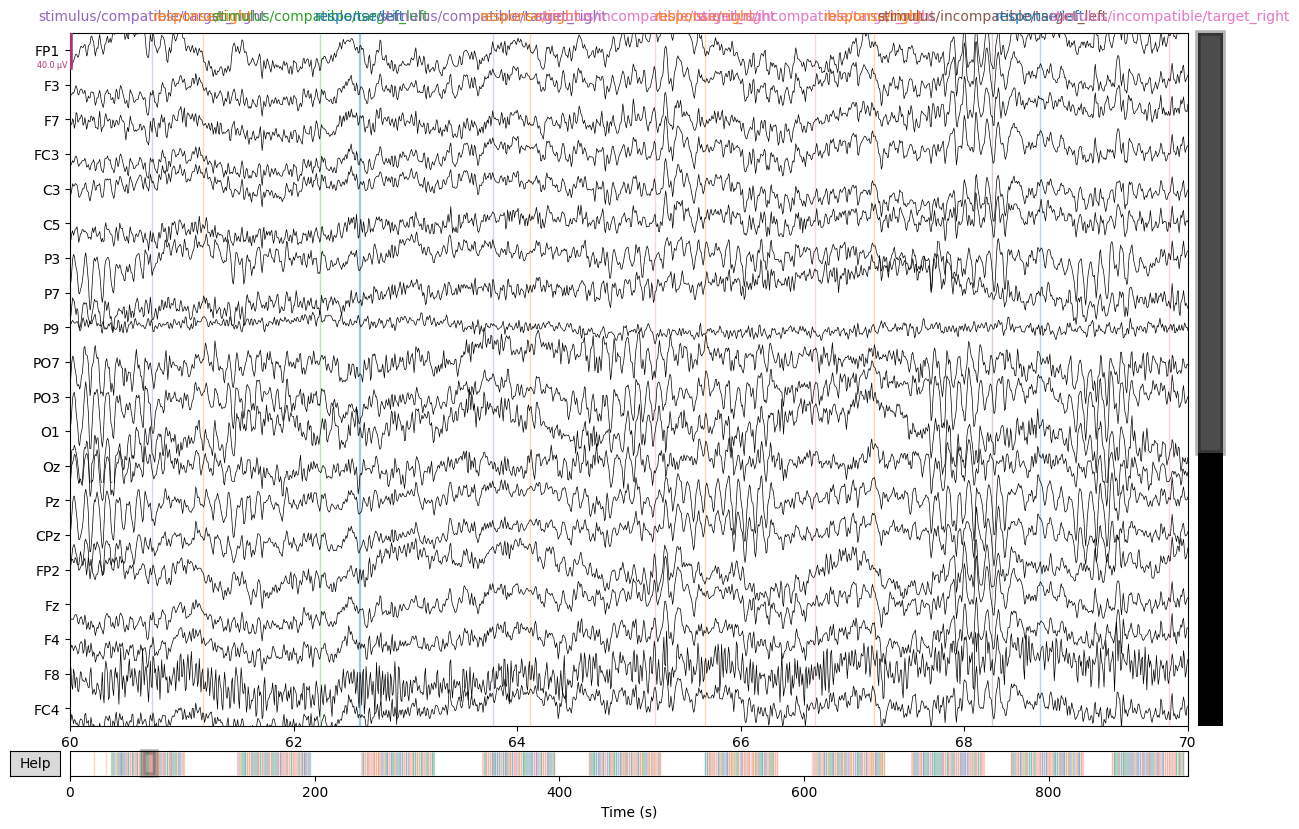

In [2]:
data_dir = mne.datasets.erp_core.data_path()
infile = data_dir / "ERP-CORE_Subject-001_Task-Flankers_eeg.fif"

raw = mne.io.read_raw(infile, preload=True)
raw.filter(l_freq=0.1, h_freq=40)
fig = raw.plot(start=60)

In [3]:
# extract events
all_events, all_event_id = mne.events_from_annotations(raw)

all_events.shape

Used Annotations descriptions: ['response/left', 'response/right', 'stimulus/compatible/target_left', 'stimulus/compatible/target_right', 'stimulus/incompatible/target_left', 'stimulus/incompatible/target_right']


(802, 3)

### Extract response events

In [4]:
metadata_tmin, metadata_tmax = -1.5, 0
row_events = ["response/left", "response/right"]
keep_last = ["stimulus", "response"]

response_metadata, response_events, response_event_id = mne.epochs.make_metadata(
    events=all_events,
    event_id=all_event_id,
    tmin=metadata_tmin,
    tmax=metadata_tmax,
    sfreq=raw.info["sfreq"],
    row_events=row_events,
    keep_last=keep_last,
)

In [5]:
response_metadata.loc[:, "stimulus_side"] = ""  # initialize column

# left-side stimulation
response_metadata.loc[
    response_metadata["last_stimulus"].isin(
        ["compatible/target_left", "incompatible/target_left"]
    ),
    "stimulus_side",
] = "left"

# right-side stimulation
response_metadata.loc[
    response_metadata["last_stimulus"].isin(
        ["compatible/target_right", "incompatible/target_right"]
    ),
    "stimulus_side",
] = "right"

# first assume all responses were incorrect, then mark those as correct where
# the stimulation side matches the response side
response_metadata["response_correct"] = False
response_metadata.loc[
    response_metadata["stimulus_side"] == response_metadata["last_response"], "response_correct"
] = True

response_metadata

,event_name,response/left,response/right,stimulus/compatible/target_left,stimulus/compatible/target_right,stimulus/incompatible/target_left,stimulus/incompatible/target_right,stimulus,response,last_stimulus,last_response,stimulus_side,response_correct
0,response/right,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,,right,,False
1,response/right,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,,right,,False
3,response/left,0.000000,NaN,-0.551758,NaN,NaN,NaN,-0.551758,0.000000,compatible/target_left,left,left,True
5,response/left,-1.431641,NaN,-0.434570,NaN,NaN,NaN,-0.434570,-1.431641,compatible/target_left,left,left,True
7,response/right,NaN,0.000000,NaN,NaN,NaN,-0.508789,-0.508789,0.000000,incompatible/target_right,right,right,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,response/left,0.000000,-1.496094,-0.496094,NaN,NaN,NaN,-0.496094,0.000000,compatible/target_left,left,left,True
795,response/right,NaN,0.000000,-1.437500,NaN,NaN,NaN,-1.437500,0.000000,compatible/target_left,right,left,False
797,response/left,0.000000,-0.576172,NaN,NaN,-0.547852,NaN,-0.547852,0.000000,incompatible/target_left,left,left,True
799,response/right,-1.343750,0.000000,NaN,NaN,NaN,-0.425781,-0.425781,0.000000,incompatible/target_right,right,right,True


In [6]:
response_events, response_event_id

(array([[ 20101,      0,      2],
        [ 30243,      0,      2],
        [ 35240,      0,      1],
        ...,
        [929312,      0,      1],
        [930688,      0,      2],
        [932114,      0,      1]]),
 {'response/left': 1, 'response/right': 2})

In [7]:
response_events_df = pd.DataFrame(response_events, columns=['latency', 'duration', 'id'])
response_events_df = pd.concat([response_events_df, response_metadata['response_correct'].reset_index(drop=True)], axis=1)
response_events_df = response_events_df.rename(columns={'response_correct': 'event_name'})
response_events_df['event_name'] = response_events_df['event_name'].map(lambda x: 'incorrect' if x is False else 'correct')
response_events_df

,latency,duration,id,event_name
0,20101,0,2,incorrect
1,30243,0,2,incorrect
2,35240,0,1,correct
3,36706,0,1,correct
4,38369,0,2,correct
...,...,...,...,...
397,926273,0,1,correct
398,928722,0,2,incorrect
399,929312,0,1,correct
400,930688,0,2,correct


## Extract stimuli events

In [8]:
metadata_tmin, metadata_tmax = 0.0, 1.5

row_events = [
    "stimulus/compatible/target_left",
    "stimulus/compatible/target_right",
    "stimulus/incompatible/target_left",
    "stimulus/incompatible/target_right",
]
keep_first = ["stimulus", "response"]

stimuli_metadata, stimuli_events, stimuli_event_id = mne.epochs.make_metadata(
    events=all_events,
    event_id=all_event_id,
    tmin=metadata_tmin,
    tmax=metadata_tmax,
    sfreq=raw.info["sfreq"],
    row_events=row_events,
    keep_first=keep_first,
)
stimuli_metadata

,event_name,response/left,response/right,stimulus/compatible/target_left,stimulus/compatible/target_right,stimulus/incompatible/target_left,stimulus/incompatible/target_right,stimulus,response,first_stimulus,first_response
2,stimulus/compatible/target_left,0.551758,NaN,0.000000,NaN,NaN,NaN,0.0,0.551758,compatible/target_left,left
4,stimulus/compatible/target_left,0.434570,NaN,0.000000,NaN,NaN,NaN,0.0,0.434570,compatible/target_left,left
6,stimulus/incompatible/target_right,NaN,0.508789,NaN,NaN,NaN,0.00000,0.0,0.508789,incompatible/target_right,right
8,stimulus/compatible/target_left,0.503906,NaN,0.000000,NaN,1.449219,NaN,0.0,0.503906,compatible/target_left,left
10,stimulus/incompatible/target_left,0.542969,NaN,NaN,NaN,0.000000,NaN,0.0,0.542969,incompatible/target_left,left
...,...,...,...,...,...,...,...,...,...,...,...
792,stimulus/compatible/target_left,0.496094,NaN,0.000000,NaN,NaN,NaN,0.0,0.496094,compatible/target_left,left
794,stimulus/compatible/target_left,NaN,1.437500,0.000000,NaN,1.465820,NaN,0.0,1.437500,compatible/target_left,right
796,stimulus/incompatible/target_left,0.547852,NaN,NaN,NaN,0.000000,1.46582,0.0,0.547852,incompatible/target_left,left
798,stimulus/incompatible/target_right,NaN,0.425781,1.416016,NaN,NaN,0.00000,0.0,0.425781,incompatible/target_right,right


In [9]:
stimuli_metadata.loc[:, "stimulus_side"] = ""  # initialize column

# left-side stimulation
stimuli_metadata.loc[
    stimuli_metadata["first_stimulus"].isin(
        ["compatible/target_left", "incompatible/target_left"]
    ),
    "stimulus_side",
] = "left"

# right-side stimulation
stimuli_metadata.loc[
    stimuli_metadata["first_stimulus"].isin(
        ["compatible/target_right", "incompatible/target_right"]
    ),
    "stimulus_side",
] = "right"

# first assume all responses were incorrect, then mark those as correct where
# the stimulation side matches the response side
stimuli_metadata["response_correct"] = False
stimuli_metadata.loc[
    stimuli_metadata["stimulus_side"] == stimuli_metadata["first_response"], "response_correct"
] = True


correct_response_count = stimuli_metadata["response_correct"].sum()
print(
    f"Correct responses: {correct_response_count}\n"
    f"Incorrect responses: {len(stimuli_metadata) - correct_response_count}"
)

Correct responses: 346
Incorrect responses: 54


In [10]:
stimuli_events, stimuli_event_id

(array([[ 34675,      0,      3],
        [ 36261,      0,      3],
        [ 37848,      0,      6],
        ...,
        [928751,      0,      5],
        [930252,      0,      6],
        [931702,      0,      3]]),
 {'stimulus/compatible/target_left': 3,
  'stimulus/compatible/target_right': 4,
  'stimulus/incompatible/target_left': 5,
  'stimulus/incompatible/target_right': 6})

In [11]:
stimuli_events_df = pd.DataFrame(stimuli_events, columns=['latency', 'duration', 'id'])
stimuli_events_df = pd.concat([stimuli_events_df, stimuli_metadata['event_name'].reset_index(drop=True)], axis=1)
stimuli_events_df

,latency,duration,id,event_name
0,34675,0,3,stimulus/compatible/target_left
1,36261,0,3,stimulus/compatible/target_left
2,37848,0,6,stimulus/incompatible/target_right
3,39401,0,3,stimulus/compatible/target_left
4,40885,0,5,stimulus/incompatible/target_left
...,...,...,...,...
395,925765,0,3,stimulus/compatible/target_left
396,927250,0,3,stimulus/compatible/target_left
397,928751,0,5,stimulus/incompatible/target_left
398,930252,0,6,stimulus/incompatible/target_right


## Merge events dataframes

In [12]:
events_df = pd.concat([stimuli_events_df, response_events_df], ignore_index=True)
events_df = events_df.sort_values(by='latency').reset_index(drop=True)
events_df

,latency,duration,id,event_name
0,20101,0,2,incorrect
1,30243,0,2,incorrect
2,34675,0,3,stimulus/compatible/target_left
3,35240,0,1,correct
4,36261,0,3,stimulus/compatible/target_left
...,...,...,...,...
797,929312,0,1,correct
798,930252,0,6,stimulus/incompatible/target_right
799,930688,0,2,correct
800,931702,0,3,stimulus/compatible/target_left


## Inspect data

Create stimuli Epochs

In [86]:
epochs_tmin, epochs_tmax = -0.5, 0.8  # epochs range: [-0.1, 0.4] s
# reject = {"eeg": 250e-6}  # exclude epochs with strong artifacts
epochs_stim = mne.Epochs(
    raw=raw,
    tmin=epochs_tmin,
    tmax=epochs_tmax,
    events=stimuli_events,
    event_id=stimuli_event_id,
    metadata=stimuli_metadata,
    # reject=reject,
    preload=True,
)

epochs_res = mne.Epochs(
    raw=raw,
    tmin=epochs_tmin,
    tmax=epochs_tmax,
    events=response_events,
    event_id=response_event_id,
    metadata=response_metadata,
    # reject=reject,
    preload=True,
)

Adding metadata with 13 columns
400 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 400 events and 1332 original time points ...
0 bad epochs dropped
Adding metadata with 13 columns
402 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 402 events and 1332 original time points ...
0 bad epochs dropped


Visualize stimuli-locked incorrect response epochs

Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_87775/4191884990.py:14: RuntimeWarning: Some values in overlay_times fall outside of the epochs time interval (between -0.5 s and 0.7998046875 s)
  sorted_epochs.plot_image(picks="FCz", overlay_times=rts[sorted_indices])


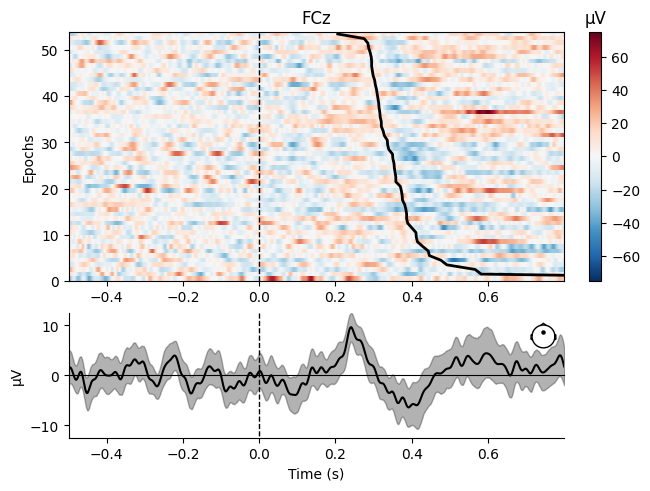

[<Figure size 640x480 with 4 Axes>]

In [90]:
incorrect_response_epochs = epochs_stim["not response_correct"]
incorrect_response_epochs

response_new_metadata_df = epochs_stim.metadata
rts = response_new_metadata_df[response_new_metadata_df['response_correct'] == False]['response'].to_numpy()

# Step 2: Get the order of the sorted RTs
sorted_indices = np.argsort(rts)[::-1]

# Step 3: Sort the epochs using the sorted indices
sorted_epochs = incorrect_response_epochs[sorted_indices]

# Step 4: Plot the sorted epochs
sorted_epochs.plot_image(picks="FCz", overlay_times=rts[sorted_indices])

Visualize response-locked incorrect epochs

Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated


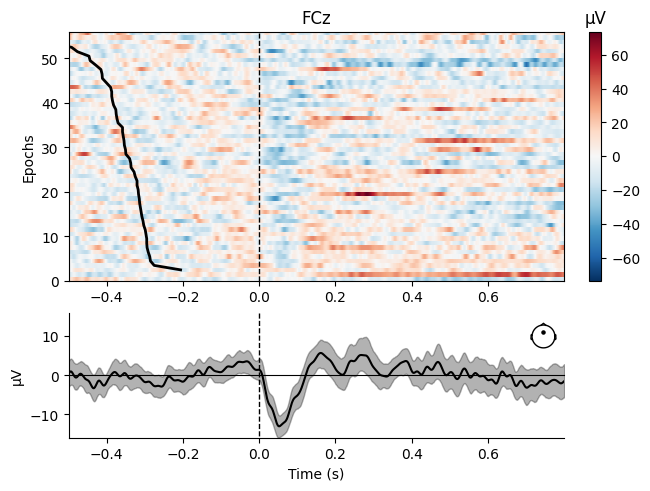

[<Figure size 640x480 with 4 Axes>]

In [91]:
incorrect_response_epochs = epochs_res["not response_correct"]

response_new_metadata_df = incorrect_response_epochs.metadata
stimulus_rts = response_new_metadata_df[response_new_metadata_df['response_correct'] == False]['stimulus'].to_numpy()

# Step 2: Get the order of the sorted RTs
sorted_indices = np.argsort(stimulus_rts)[::-1]

# Step 3: Sort the epochs using the sorted indices
sorted_epochs = incorrect_response_epochs[sorted_indices]

# Step 4: Plot the sorted epochs
sorted_epochs.plot_image(picks="FCz", overlay_times=stimulus_rts[sorted_indices])

## Unfold

In [18]:
# Import the Julia package manager
from juliacall import Pkg as jlPkg

# Activate the environment in the current folder
jlPkg.activate(".")

# Check the status of the environment/installed packages -> will be empty at the beginning
print(jlPkg.status())

# Install Julia packages
jlPkg.add("Unfold")
jlPkg.add("DataFrames")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/Projects/neuroNoodle`


Status `~/Projects/neuroNoodle/Project.toml`
  [336ed68f] CSV v0.10.14
  [13f3f980] CairoMakie v0.12.5
  [717857b8] DSP v0.7.9
  [a93c6f00] DataFrames v1.6.1
  [ff71e718] MixedModels v4.25.1
  [3eaba693] StatsModels v0.7.3
  [181c99d8] Unfold v0.7.4
  [69a5ce3b] UnfoldMakie v0.5.4
None
  [ed8ae6d2] UnfoldSim v0.3.2


   Resolving package versions...
  No Changes to `~/Projects/neuroNoodle/Project.toml`
  No Changes to `~/Projects/neuroNoodle/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Projects/neuroNoodle/Project.toml`
  No Changes to `~/Projects/neuroNoodle/Manifest.toml`


In [19]:
from juliacall import Main as jl

# The function seval() can be used to evaluate a piece of Julia code given as a string
jl.seval("using DataFrames")
jl.seval("using Unfold")
Unfold = jl.Unfold

### Create Unfold model

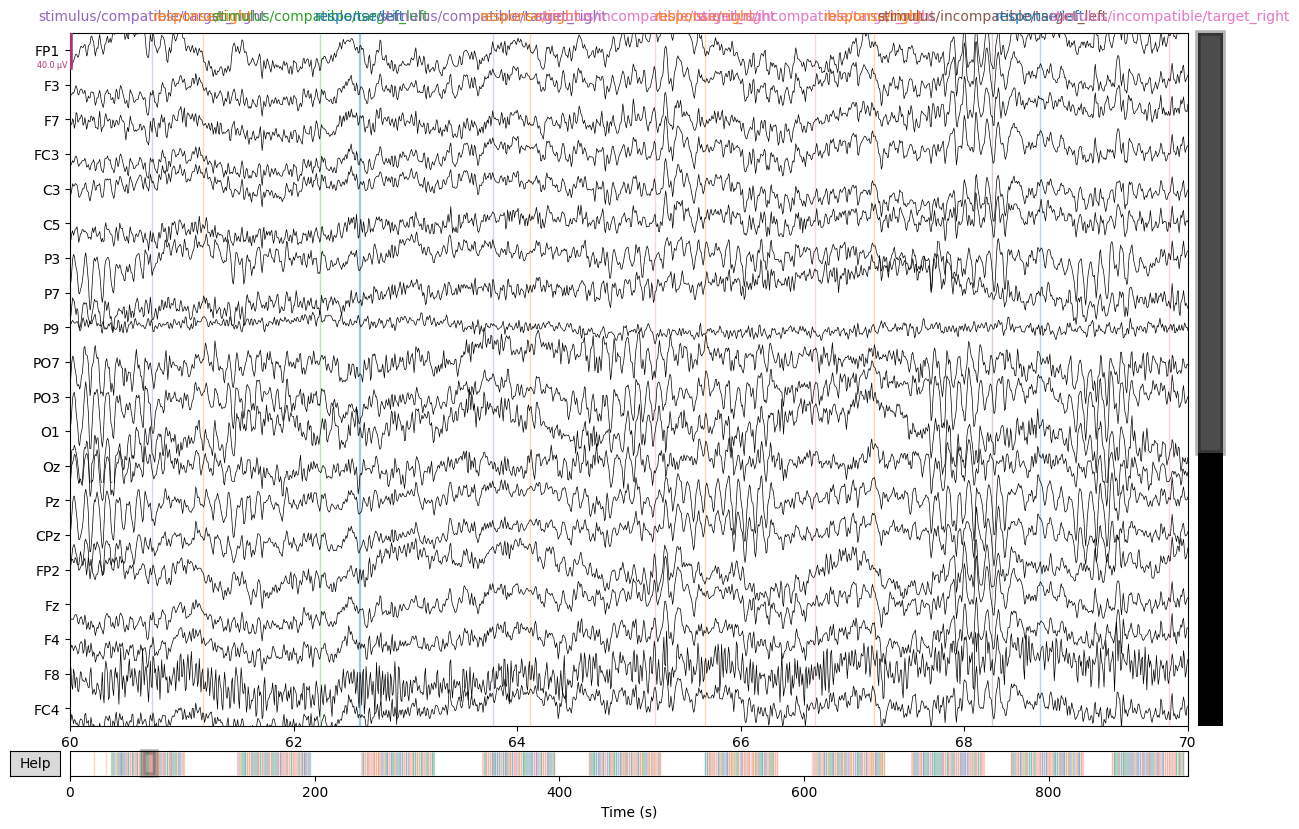

In [20]:
fig = raw.plot(start=60)

In [21]:
data = raw.get_data(picks='FCz')
print(raw.info['sfreq'])
data.shape

1024.0


(1, 935936)

In [22]:
events_df['type'] = events_df['event_name'].map(lambda x: 'response' if ((x == 'correct') or (x == 'incorrect')) else 'stimuli')
events_df

,latency,duration,id,event_name,type
0,20101,0,2,incorrect,response
1,30243,0,2,incorrect,response
2,34675,0,3,stimulus/compatible/target_left,stimuli
3,35240,0,1,correct,response
4,36261,0,3,stimulus/compatible/target_left,stimuli
...,...,...,...,...,...
797,929312,0,1,correct,response
798,930252,0,6,stimulus/incompatible/target_right,stimuli
799,930688,0,2,correct,response
800,931702,0,3,stimulus/compatible/target_left,stimuli


In [23]:
# Specify model formula
bf_stimuli = jl.seval("bf_stimuli = firbasis(τ = (-0.3, 0.5), sfreq = 1024)")
bf_response = jl.seval("bf_response = firbasis(τ = (-0.3, 0.5), sfreq = 1024)")

formula = jl.seval("f = @formula 0 ~ 1")
bfDict = jl.seval("[ \"stimuli\" => (f, bf_stimuli), \"response\" => (f, bf_response) ]")

# Convert the Python columns to Julia arrays
type_column = jl.seval("Vector{String}")(events_df['type'].tolist())
latency_column = jl.seval("Vector{Int64}")(events_df['latency'].tolist())

# Create the Julia DataFrame
events_df_jl = jl.DataFrame(type=type_column, latency=latency_column)

# Fit Unfold model
m = Unfold.fit(
    Unfold.UnfoldModel,
    bfDict,
    events_df_jl,
    data,
    # solver = jl.seval("(x, y) -> Unfold.solver_default(x, y; stderror = true)"),
    eventcolumn = "type",
)

In [24]:
# Extract coefficient table
results_jl = Unfold.coeftable(m)

# Transfer results back to Python
results_py_df = pd.DataFrame({
    'channel': results_jl.channel,
    'coefname': results_jl.coefname,
    'estimate': results_jl.estimate,
    'eventname': results_jl.eventname,
    'group': results_jl.group,
    'stderror': results_jl.stderror,
    'time': results_jl.time
})

results_py_df.head()

,channel,coefname,estimate,eventname,group,stderror,time
0,1,(Intercept),-0.000002,stimuli,None,None,-0.299805
1,1,(Intercept),-0.000002,stimuli,None,None,-0.298828
2,1,(Intercept),-0.000002,stimuli,None,None,-0.297852
3,1,(Intercept),-0.000002,stimuli,None,None,-0.296875
4,1,(Intercept),-0.000002,stimuli,None,None,-0.295898


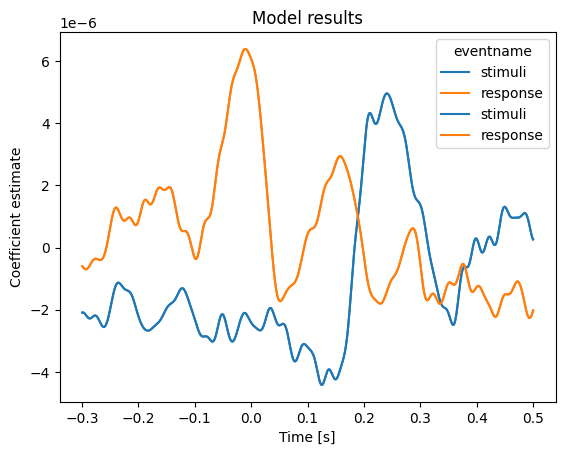

In [26]:
# Extract the coefficients for one channel
results_ch = results_py_df[results_py_df.channel == 1]

# Plot the coefficient estimates over time
ax = sns.lineplot(x = results_ch.time,y=results_ch.estimate,hue=results_ch.eventname)
ax.set(xlabel='Time [s]', ylabel='Coefficient estimate', title='Model results');

plt.show()

In [27]:
results_py_df

,channel,coefname,estimate,eventname,group,stderror,time
0,1,(Intercept),-0.000002,stimuli,None,None,-0.299805
1,1,(Intercept),-0.000002,stimuli,None,None,-0.298828
2,1,(Intercept),-0.000002,stimuli,None,None,-0.297852
3,1,(Intercept),-0.000002,stimuli,None,None,-0.296875
4,1,(Intercept),-0.000002,stimuli,None,None,-0.295898
...,...,...,...,...,...,...,...
1635,1,(Intercept),-0.000002,response,None,None,0.496094
1636,1,(Intercept),-0.000002,response,None,None,0.497070
1637,1,(Intercept),-0.000002,response,None,None,0.498047
1638,1,(Intercept),-0.000002,response,None,None,0.499023


---

Get predicted (modelled) raw signal

In [50]:
raw_modelled = Unfold.predict(m, overlap=True) # predicted signal -> model 
raw_modelled = raw_modelled.to_numpy()
raw_modelled.shape

(1, 932626)

Extract residuals

In [51]:
residuals = data.flatten()[:raw_modelled.shape[-1]] - raw_modelled
residuals.shape

(1, 932626)

Extract model matrix

In [30]:
model_matrix = Unfold.modelmatrix(m) # n_samples of raw x n_samples of basis functions of events
model_matrix = model_matrix.to_numpy()
print(model_matrix.shape)

(932626, 1640)


Model raw separately for response and the stimuli

In [32]:
betas = results_py_df.copy()

betas['estimate_response'] = betas['estimate']
betas.loc[betas['eventname'] == 'stimuli', 'estimate_response'] = 0

betas['estimate_stimuli'] = betas['estimate']
betas.loc[betas['eventname'] == 'response', 'estimate_stimuli'] = 0

betas.head()

,channel,coefname,estimate,eventname,group,stderror,time,estimate_response,estimate_stimuli
0,1,(Intercept),-0.000002,stimuli,None,None,-0.299805,0.0,-0.000002
1,1,(Intercept),-0.000002,stimuli,None,None,-0.298828,0.0,-0.000002
2,1,(Intercept),-0.000002,stimuli,None,None,-0.297852,0.0,-0.000002
3,1,(Intercept),-0.000002,stimuli,None,None,-0.296875,0.0,-0.000002
4,1,(Intercept),-0.000002,stimuli,None,None,-0.295898,0.0,-0.000002


In [33]:
predicted_raw_response = np.dot(model_matrix, betas['estimate_response'].to_numpy())
print(predicted_raw_response.shape)

predicted_raw_stimuli = np.dot(model_matrix, betas['estimate_stimuli'].to_numpy())
print(predicted_raw_stimuli.shape)

(932626,)
(932626,)


Inspect separated raws

In [106]:
sfreq = 1024  # Sampling frequency in Hz
ch_names = ['FCz']  # Channel name
ch_types = ['eeg']  # Channel type

# Step 2: Create the info object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

mne_raw_stimuli = mne.io.RawArray(predicted_raw_stimuli.reshape(1,-1), info = info)
mne_raw_response = mne.io.RawArray(predicted_raw_response.reshape(1,-1), info = info)

Creating RawArray with float64 data, n_channels=1, n_times=932626
    Range : 0 ... 932625 =      0.000 ...   910.767 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=932626
    Range : 0 ... 932625 =      0.000 ...   910.767 secs
Ready.


Adding metadata with 13 columns
400 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 400 events and 1332 original time points ...
0 bad epochs dropped
Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_87775/1614765224.py:14: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_stimuli.plot_image(picks="FCz")


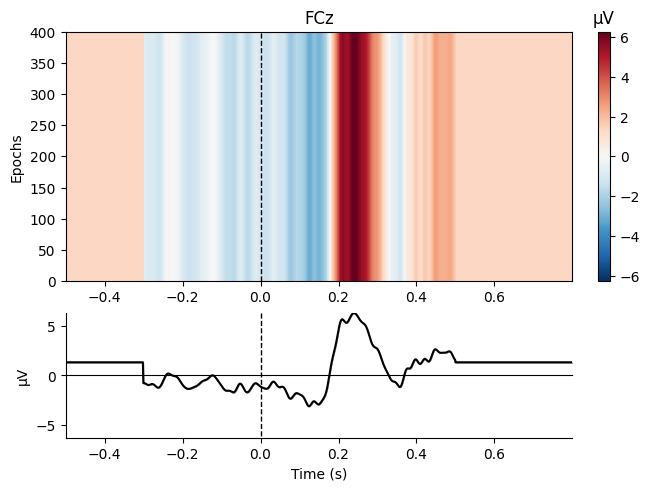

[<Figure size 640x480 with 3 Axes>]

In [107]:
epochs_tmin, epochs_tmax = -0.5, 0.8  # epochs range: [-0.1, 0.4] s
# reject = {"eeg": 250e-6}  # exclude epochs with strong artifacts
epochs_stimuli = mne.Epochs(
    raw=mne_raw_stimuli,
    tmin=epochs_tmin,
    tmax=epochs_tmax,
    events=stimuli_events,
    event_id=stimuli_event_id,
    metadata=stimuli_metadata,
    # reject=reject,
    preload=True,
)

epochs_stimuli.plot_image(picks="FCz")

Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_87775/3974355243.py:13: RuntimeWarning: Some values in overlay_times fall outside of the epochs time interval (between -0.5 s and 0.7998046875 s)
  sorted_epochs.plot_image(picks="FCz", overlay_times=rts[sorted_indices])
/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_87775/3974355243.py:13: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  sorted_epochs.plot_image(picks="FCz", overlay_times=rts[sorted_indices])


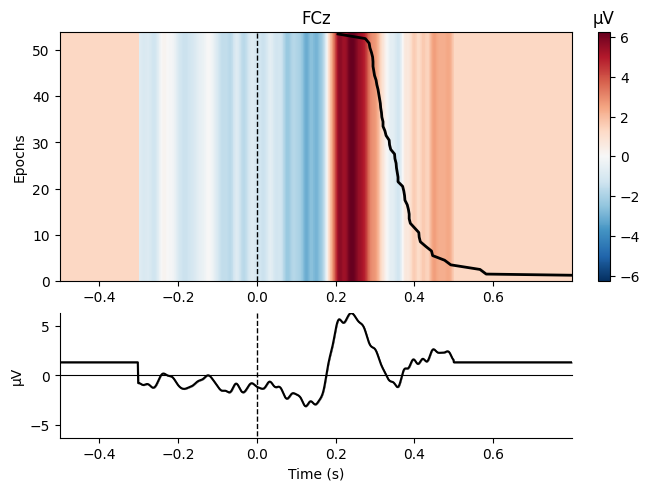

[<Figure size 640x480 with 3 Axes>]

In [108]:
incorrect_response_epochs = epochs_stimuli["not response_correct"]

response_new_metadata_df = incorrect_response_epochs.metadata
rts = response_new_metadata_df[response_new_metadata_df['response_correct'] == False]['response'].to_numpy()

# Step 2: Get the order of the sorted RTs
sorted_indices = np.argsort(rts)[::-1]

# Step 3: Sort the epochs using the sorted indices
sorted_epochs = incorrect_response_epochs[sorted_indices]

# Step 4: Plot the sorted epochs
sorted_epochs.plot_image(picks="FCz", overlay_times=rts[sorted_indices])

Adding metadata with 13 columns
402 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 402 events and 1332 original time points ...
1 bad epochs dropped
Not setting metadata
401 matching events found
No baseline correction applied
0 projection items activated


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_87775/2600230800.py:14: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_response.plot_image(picks="FCz")


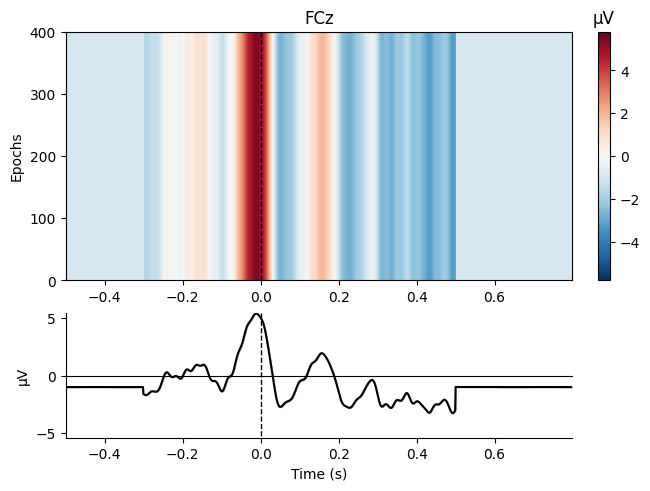

[<Figure size 640x480 with 3 Axes>]

In [109]:
epochs_tmin, epochs_tmax = -0.5, 0.8  # epochs range: [-0.1, 0.4] s
# reject = {"eeg": 250e-6}  # exclude epochs with strong artifacts
epochs_response = mne.Epochs(
    raw=mne_raw_response,
    tmin=epochs_tmin,
    tmax=epochs_tmax,
    events=response_events,
    event_id=response_event_id,
    metadata=response_metadata,
    # reject=reject,
    preload=True,
)

epochs_response.plot_image(picks="FCz")

Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_87775/4149017480.py:13: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  sorted_epochs.plot_image(picks="FCz", overlay_times=stimulus_rts[sorted_indices])


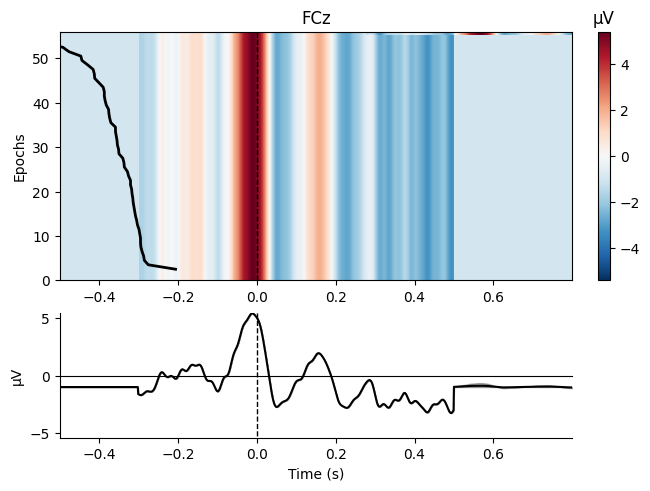

[<Figure size 640x480 with 3 Axes>]

In [110]:
incorrect_response_epochs = epochs_response["not response_correct"]

response_new_metadata_df = incorrect_response_epochs.metadata
stimulus_rts = response_new_metadata_df[response_new_metadata_df['response_correct'] == False]['stimulus'].to_numpy()

# Step 2: Get the order of the sorted RTs
sorted_indices = np.argsort(stimulus_rts)[::-1]

# Step 3: Sort the epochs using the sorted indices
sorted_epochs = incorrect_response_epochs[sorted_indices]

# Step 4: Plot the sorted epochs
sorted_epochs.plot_image(picks="FCz", overlay_times=stimulus_rts[sorted_indices])

Add residuals to raws

In [111]:
predicted_raw_response_residuals = predicted_raw_response + residuals
print(predicted_raw_response_residuals.shape)
predicted_raw_stimuli_residuals = predicted_raw_stimuli + residuals
print(predicted_raw_stimuli_residuals.shape)

(1, 932626)
(1, 932626)


In [112]:
sfreq = 1024  # Sampling frequency in Hz
ch_names = ['FCz']  # Channel name
ch_types = ['eeg']  # Channel type

# Step 2: Create the info object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

mne_raw_stimuli_res = mne.io.RawArray(predicted_raw_stimuli_residuals.reshape(1,-1), info = info)
mne_raw_response_res = mne.io.RawArray(predicted_raw_response_residuals.reshape(1,-1), info = info)

Creating RawArray with float64 data, n_channels=1, n_times=932626
    Range : 0 ... 932625 =      0.000 ...   910.767 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=932626
    Range : 0 ... 932625 =      0.000 ...   910.767 secs
Ready.


Stimuli epochs

Adding metadata with 13 columns
400 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 400 events and 1332 original time points ...
0 bad epochs dropped
Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_87775/1931879821.py:14: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_stimuli_res.plot_image(picks="FCz")


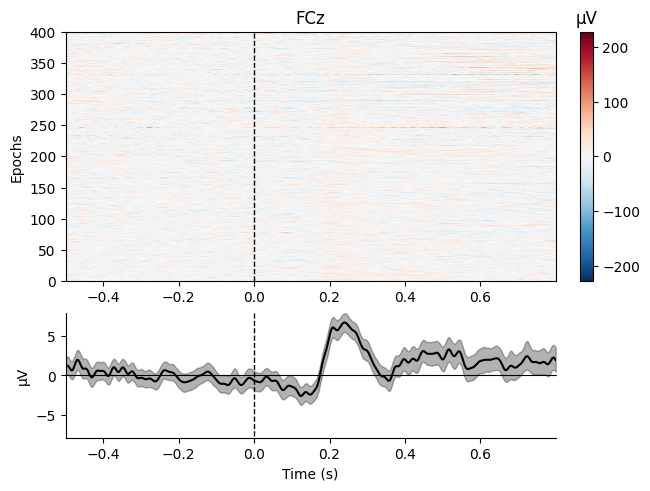

[<Figure size 640x480 with 3 Axes>]

In [113]:
epochs_tmin, epochs_tmax = -0.5, 0.8  # epochs range: [-0.1, 0.4] s
# reject = {"eeg": 250e-6}  # exclude epochs with strong artifacts
epochs_stimuli_res = mne.Epochs(
    raw=mne_raw_stimuli_res,
    tmin=epochs_tmin,
    tmax=epochs_tmax,
    events=stimuli_events,
    event_id=stimuli_event_id,
    metadata=stimuli_metadata,
    # reject=reject,
    preload=True,
)

epochs_stimuli_res.plot_image(picks="FCz")

Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_87775/4290104628.py:13: RuntimeWarning: Some values in overlay_times fall outside of the epochs time interval (between -0.5 s and 0.7998046875 s)
  sorted_epochs.plot_image(picks="FCz", overlay_times=rts[sorted_indices])
/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_87775/4290104628.py:13: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  sorted_epochs.plot_image(picks="FCz", overlay_times=rts[sorted_indices])


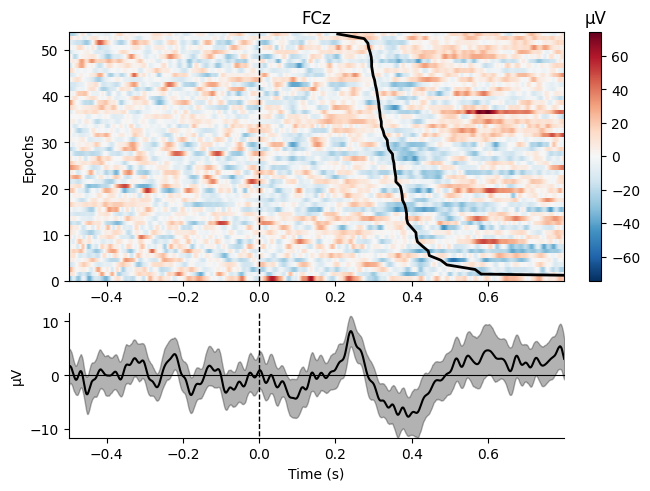

[<Figure size 640x480 with 3 Axes>]

In [114]:
incorrect_response_epochs = epochs_stimuli_res["not response_correct"]

response_new_metadata_df = incorrect_response_epochs.metadata
rts = response_new_metadata_df[response_new_metadata_df['response_correct'] == False]['response'].to_numpy()

# Step 2: Get the order of the sorted RTs
sorted_indices = np.argsort(rts)[::-1]

# Step 3: Sort the epochs using the sorted indices
sorted_epochs = incorrect_response_epochs[sorted_indices]

# Step 4: Plot the sorted epochs
sorted_epochs.plot_image(picks="FCz", overlay_times=rts[sorted_indices])

Adding metadata with 13 columns
402 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 402 events and 1332 original time points ...
1 bad epochs dropped
Not setting metadata
401 matching events found
No baseline correction applied
0 projection items activated


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_87775/3857062833.py:14: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_response_res.plot_image(picks="FCz")


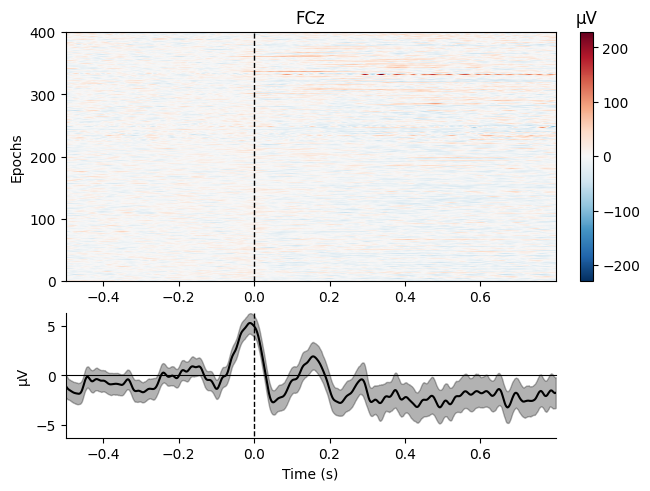

[<Figure size 640x480 with 3 Axes>]

In [115]:
epochs_tmin, epochs_tmax = -0.5, 0.8  # epochs range: [-0.1, 0.4] s
# reject = {"eeg": 250e-6}  # exclude epochs with strong artifacts
epochs_response_res = mne.Epochs(
    raw=mne_raw_response_res,
    tmin=epochs_tmin,
    tmax=epochs_tmax,
    events=response_events,
    event_id=response_event_id,
    metadata=response_metadata,
    # reject=reject,
    preload=True,
)

epochs_response_res.plot_image(picks="FCz")

Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_87775/2396435258.py:13: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  sorted_epochs.plot_image(picks="FCz", overlay_times=stimulus_rts[sorted_indices])


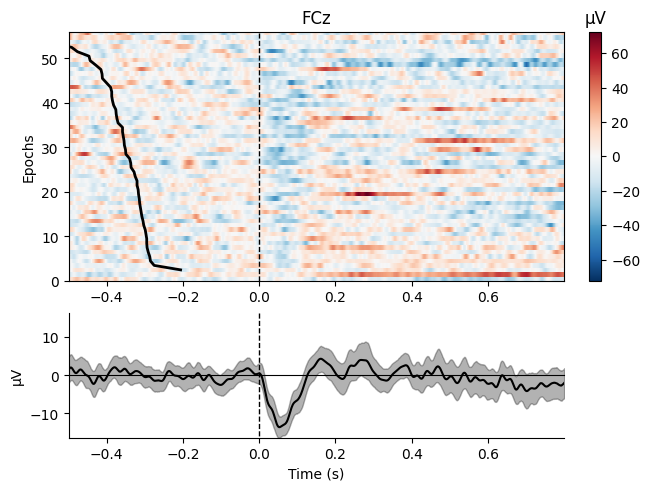

[<Figure size 640x480 with 3 Axes>]

In [116]:
incorrect_response_epochs = epochs_response_res["not response_correct"]

response_new_metadata_df = incorrect_response_epochs.metadata
stimulus_rts = response_new_metadata_df[response_new_metadata_df['response_correct'] == False]['stimulus'].to_numpy()

# Step 2: Get the order of the sorted RTs
sorted_indices = np.argsort(stimulus_rts)[::-1]

# Step 3: Sort the epochs using the sorted indices
sorted_epochs = incorrect_response_epochs[sorted_indices]

# Step 4: Plot the sorted epochs
sorted_epochs.plot_image(picks="FCz", overlay_times=stimulus_rts[sorted_indices])

Look into the residuals

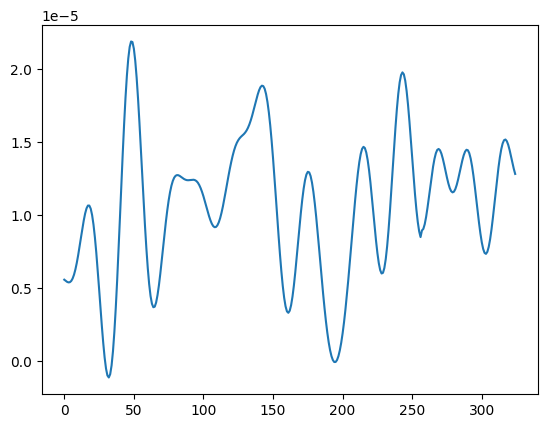

In [117]:
plt.plot(residuals.flatten()[34675:35000])
plt.show()

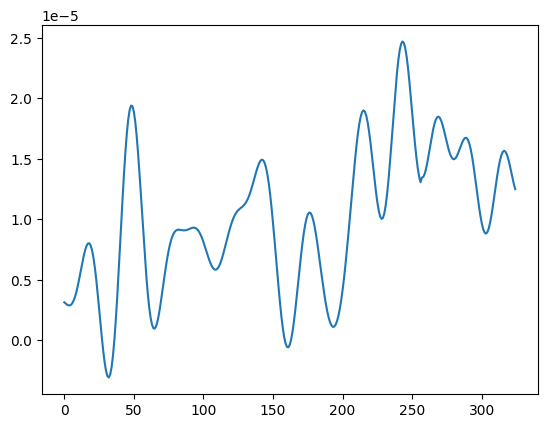

In [118]:
plt.plot(predicted_raw_stimuli_residuals.flatten()[34675:35000])
plt.show()

In [119]:
predicted_raw_stimuli_residuals.shape

(1, 932626)

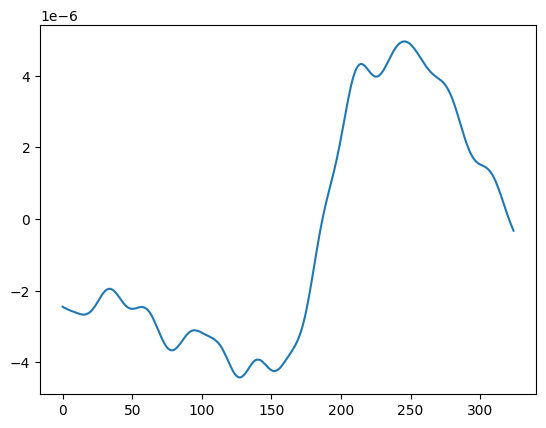

In [120]:
plt.plot(predicted_raw_stimuli.flatten()[34675:35000])
plt.show()

---

In [198]:
d = Unfold.predict(m, overlap=False)

In [180]:
stimuli_data = d[0].to_numpy()
response_data = d[1].to_numpy()

stimuli_data_transposed = stimuli_data.transpose(2,0,1)
response_data_transposed = response_data.transpose(2,0,1)

In [181]:
sfreq = 1024  # Sampling frequency in Hz
ch_names = ['FCz']  # Channel name
ch_types = ['eeg']  # Channel type

# Step 2: Create the info object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

stimuli_epochs = mne.EpochsArray(stimuli_data_transposed, info, tmin=-0.3)
response_epochs = mne.EpochsArray(response_data_transposed, info, tmin=-0.3)

Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
402 matching events found
No baseline correction applied
0 projection items activated


In [182]:
stimuli_epochs, response_epochs

(<EpochsArray |  400 events (all good), -0.299805 – 0.5 s, baseline off, ~2.5 MB, data loaded,
  '1': 400>,
 <EpochsArray |  402 events (all good), -0.299805 – 0.5 s, baseline off, ~2.5 MB, data loaded,
  '1': 402>)

Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_84796/1384164072.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  stimuli_epochs.plot_image(picks="FCz")


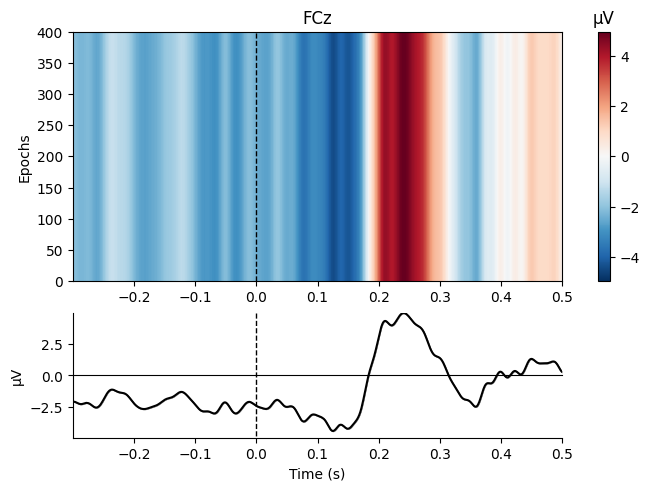

[<Figure size 640x480 with 3 Axes>]

In [183]:
stimuli_epochs.plot_image(picks="FCz")

Not setting metadata
402 matching events found
No baseline correction applied
0 projection items activated


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_84796/1232307481.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  response_epochs.plot_image(picks="FCz")


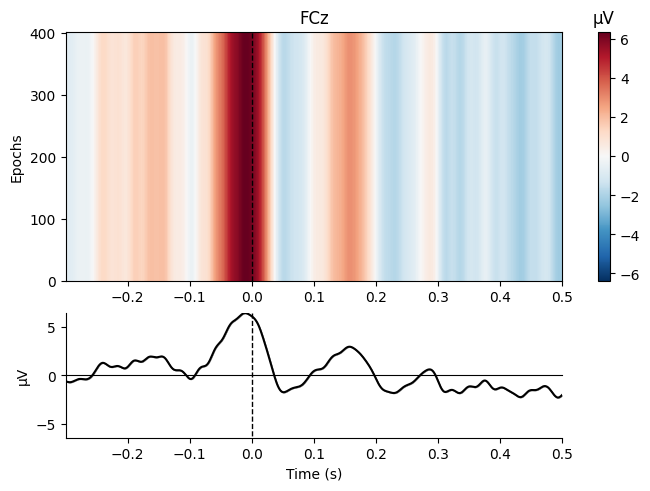

[<Figure size 640x480 with 3 Axes>]

In [184]:
response_epochs.plot_image(picks="FCz")

---

In [193]:
original_epcohs_data = epochs.get_data(picks='FCz').shape

(400, 1, 820)

In [192]:
stimuli_epochs_data = stimuli_epochs.get_data().shape

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_84796/1131132717.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  stimuli_epochs.get_data().shape


(400, 1, 820)